In [28]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [29]:
!apt-get update
!apt-get install -y fonts-noto


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease         
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                                      
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease                                    
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                                          
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease                          
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' a

In [30]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [31]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [32]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [33]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [34]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [35]:
df.head()

,id,caption,label
4677,4678,এ যেন এক সুগন্ধির মহাকাব্য!\nযার পঙক্তিমালায় র...,Non Informative
2042,2043,জন্মদিনে ১২ ফ্লেভারের ৩৬ ইঞ্চি পিৎজা পাবেন,Non Informative
410,411,মংলায় ঝড়ের তাণ্ডবে বিদ্যুতের লাইন বিচ্ছিন্ন,Cyclone
4607,4608,"ফটিকছড়ি, বাংলাদেশের চট্টগ্রাম বিভাগ এর একটি উ...",Non Informative
1483,1484,ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...,Anthropogenic


In [36]:
# Define label mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [37]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [38]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [39]:
# Define the transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('csebuetnlp/banglabert')



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [40]:
# Custom Dataset
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'anthropogenic': 4
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 4, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [41]:
# Create datasets and dataloaders
images_folder = '/kaggle/input/mddb-images/Photos_Final'
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, image_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, image_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, image_transforms)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [42]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1596
532
533


In [43]:
# Define model
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name='csebuetnlp/banglabert', num_labels=5):
        super(MultimodalModel, self).__init__()
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.image_model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.image_model.classifier = nn.Linear(self.image_model.classifier[1].in_features, 768)
        self.classifier = nn.Linear(768 * 2, num_labels)

    def forward(self, input_ids, attention_mask, image):
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.last_hidden_state[:, 0, :]
        image_embeds = self.image_model(image)
        combined_embeds = torch.cat((text_embeds, image_embeds), dim=1)
        logits = self.classifier(combined_embeds)
        return logits

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermedi

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Total Parameters: 90.65M
FLOPs: 180.75G


Epoch 1 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


Epoch 1, Train Loss: 1.5441, Train Acc: 0.3315, Val Loss: 1.4091, Val Acc: 0.4455


Epoch 2 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 2, Train Loss: 1.1707, Train Acc: 0.6096, Val Loss: 0.8386, Val Acc: 0.7838


Epoch 3 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 3, Train Loss: 0.7657, Train Acc: 0.8409, Val Loss: 0.7084, Val Acc: 0.8553


Epoch 4 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


Epoch 4, Train Loss: 0.5847, Train Acc: 0.9305, Val Loss: 0.6506, Val Acc: 0.8947


Epoch 5 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


Epoch 5, Train Loss: 0.5629, Train Acc: 0.9480, Val Loss: 0.6660, Val Acc: 0.8872


Epoch 6 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch 6, Train Loss: 0.5568, Train Acc: 0.9543, Val Loss: 0.6493, Val Acc: 0.9004


Epoch 7 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.50it/s]


Epoch 7, Train Loss: 0.5437, Train Acc: 0.9555, Val Loss: 0.6437, Val Acc: 0.9004


Epoch 8 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


Epoch 8, Train Loss: 0.5417, Train Acc: 0.9561, Val Loss: 0.6448, Val Acc: 0.9004


Epoch 9 [Val]: 100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


Epoch 9, Train Loss: 0.5418, Train Acc: 0.9580, Val Loss: 0.6414, Val Acc: 0.9041


Epoch 10 [Val]: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 10, Train Loss: 0.5425, Train Acc: 0.9612, Val Loss: 0.6411, Val Acc: 0.9041


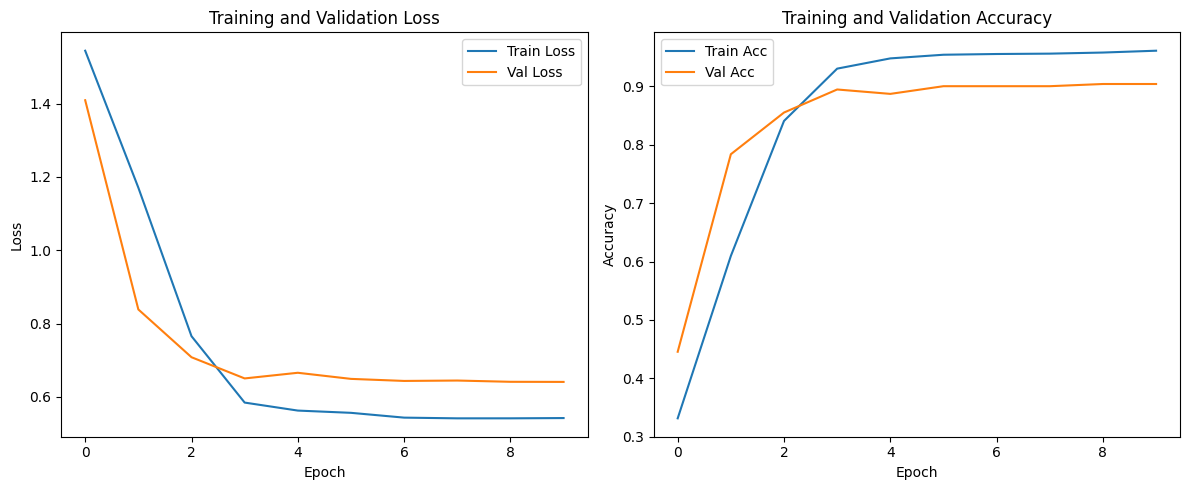

In [44]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalModel(num_labels=5).to(device)

# Calculate parameters and FLOPs (optional)
sample_batch = next(iter(train_loader))
sample_input_ids = sample_batch['input_ids'].to(device)
sample_attention_mask = sample_batch['attention_mask'].to(device)
sample_image = sample_batch['image'].to(device)
flops, params = profile(model, inputs=(sample_input_ids, sample_attention_mask, sample_image))
print(f"Total Parameters: {params/1e6:.2f}M")
print(f"FLOPs: {flops/1e9:.2f}G")

# Optimizer, criterion, and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_model(model, train_loader, valid_loader, epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"Epoch {epoch+1} [Val]"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask, images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(valid_loader)
        val_acc = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step()

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, valid_loader)


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert indices to class names
    index_to_class = {0: 'flood', 1: 'cyclone', 2: 'earthquake', 3: 'river erosion', 4: 'anthropogenic'}
    all_labels = [index_to_class[label] for label in all_labels]
    all_preds = [index_to_class[pred] for pred in all_preds]

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')  # Macro F1 score
    report = classification_report(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision (Weighted): {precision:.4f}")
    print(f"Test Recall (Weighted): {recall:.4f}")
    print(f"Test F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Test F1 Score (Macro): {f1_macro:.4f}")
    print("Classification Report:\n", report)

    # Confusion matrix
    labels = ['flood', 'cyclone', 'earthquake', 'river erosion', 'anthropogenic']
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


<ipython-input-54-1c64671aff0c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Test Accuracy: 0.8931
Test Precision (Weighted): 0.8935
Test Recall (Weighted): 0.8931
Test F1 Score (Weighted): 0.8930
Test F1 Score (Macro): 0.8921
Classification Report:
                precision    recall  f1-score   support

anthropogenic       0.90      0.93      0.92       123
      cyclone       0.83      0.85      0.84       101
   earthquake       0.93      0.90      0.91       118
        flood       0.89      0.86      0.87       105
river erosion       0.91      0.92      0.91        86

     accuracy                           0.89       533
    macro avg       0.89      0.89      0.89       533
 weighted avg       0.89      0.89      0.89       533



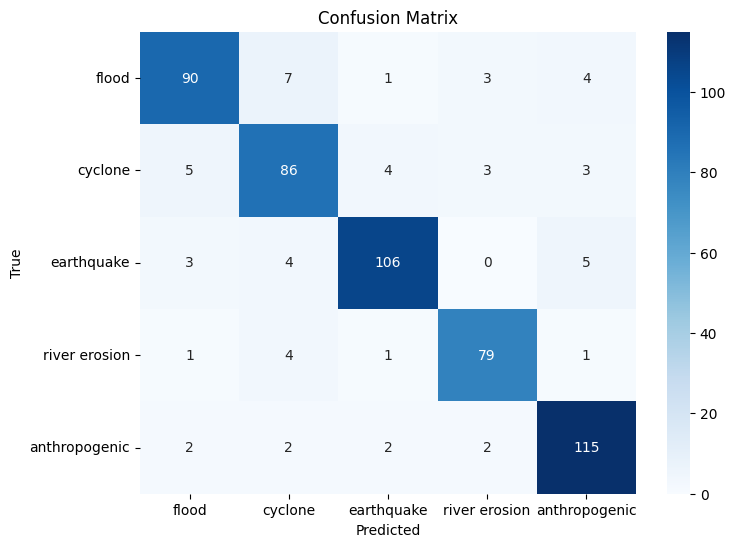

In [54]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pt'))
evaluate_model(model, test_loader)

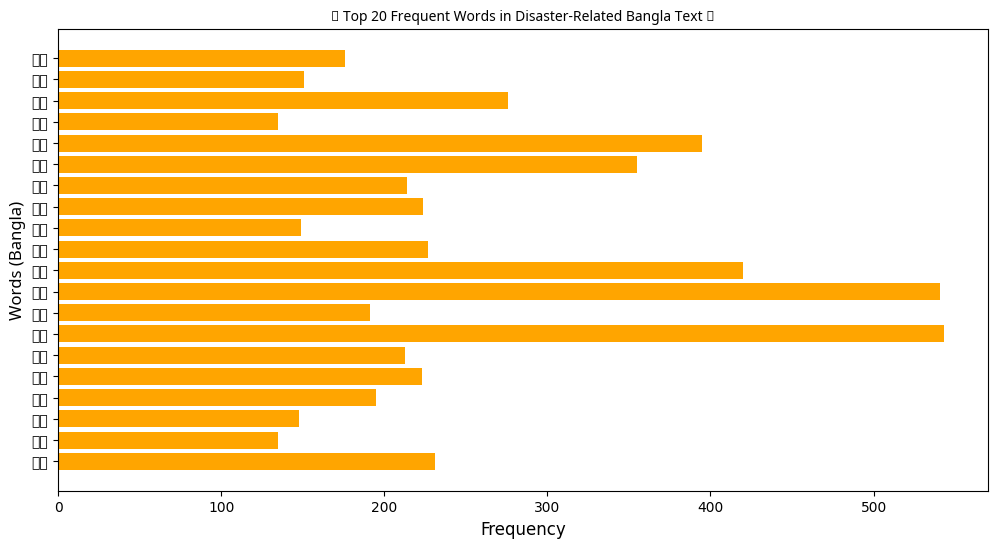

In [51]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.feature_extraction.text import CountVectorizer

bangla_stop_words = ['এবং', 'কিন্তু', 'যদি', 'এই', 'তারপর', 'জন্য', 'একটি', 'কোন', 'সাথে', 'হতে', 'বা', 'তাই', 'যখন', 'তাদের', 'অনেক', 'হয়', 'করেছে']
vectorizer = CountVectorizer(stop_words=bangla_stop_words, max_features=20)
X = vectorizer.fit_transform(df['caption'])
words = vectorizer.get_feature_names_out()
word_count = X.sum(axis=0).A1
word_freq = dict(zip(words, word_count))

# Use a font with Bangla and Latin support
font_path = "/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf"
font_prop = fm.FontProperties(fname=font_path)

plt.figure(figsize=(12, 6))
plt.barh(list(word_freq.keys()), list(word_freq.values()), color='orange')
plt.xlabel('Frequency', fontsize=12)  # English - default font
plt.ylabel('Words (Bangla)', fontsize=12, fontproperties=font_prop)  # Bangla only
plt.title('🔹 Top 20 Frequent Words in Disaster-Related Bangla Text 🔹', fontsize=14, fontproperties=font_prop)  # Mix
plt.gca().invert_yaxis()
plt.show()
